# Lung Analysis

In [22]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [23]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Preprocessing

In [90]:
# file directories
workingDirectory = '/home/jenhan/analysis/lung_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10', 'hg38']
scratchDirectory = workingDirectory + '/scratch/'
tagDirPath = workingDirectory + '/tag_directories_rna/'
idrDirectory = workingDirectory + '/idr/'

os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
originalNames = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[1].strip()
    owner = metaDataTokens[4].strip()
    date = metaDataTokens[3].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.replace('lung','')
    simpleTreatments.append(st)
metadata_frame['Cell Type'] = simpleTreatments

# ### read in log files ###

# create data frame summarizing mapping quality logs
# _unpairedReads = []
# _unmappedReads = []
# _uniquelyMappedReads = []
# _multiMappedReads = []
# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

# for logFile in os.listdir(logFilePath):
#     with open(logFilePath + '/' + logFile) as f:
#         data = f.readlines()
#     rootName = logFile
#     for gen in genomes:
#         rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
#     totalReads = int(data[5].split()[5])
#     uniquelyMappedReads = int(data[8].split()[5])
#     multiMappedReads = int(data[23].split()[8])
#     unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     _originalNames.append(rootName)
#     _totalReads.append(totalReads)
#     _unmappedReads.append(unmappedReads)
#     _uniquelyMappedReads.append(uniquelyMappedReads)
#     _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
#                                    _unpairedReads, 
#                                    _unmappedReads, 
#                                    _uniquelyMappedReads, 
#                                    _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
#                               'unpairedReads', 
#                               'unmappedReads', 
#                               'uniquelyMappedReads', 
#                               'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
# mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
# mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['Cell Type'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

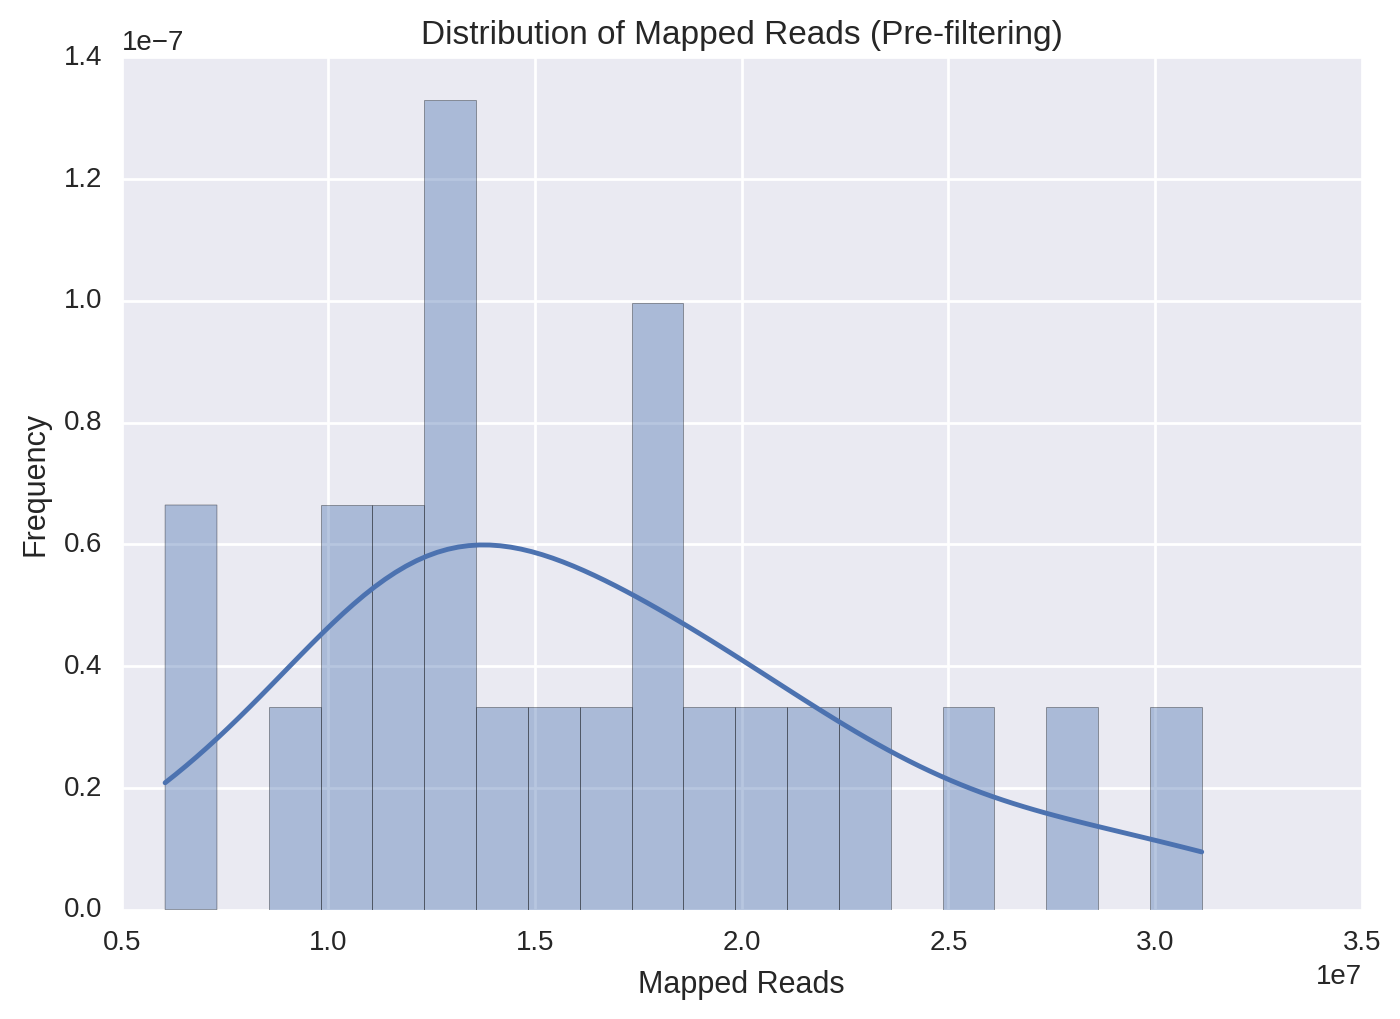

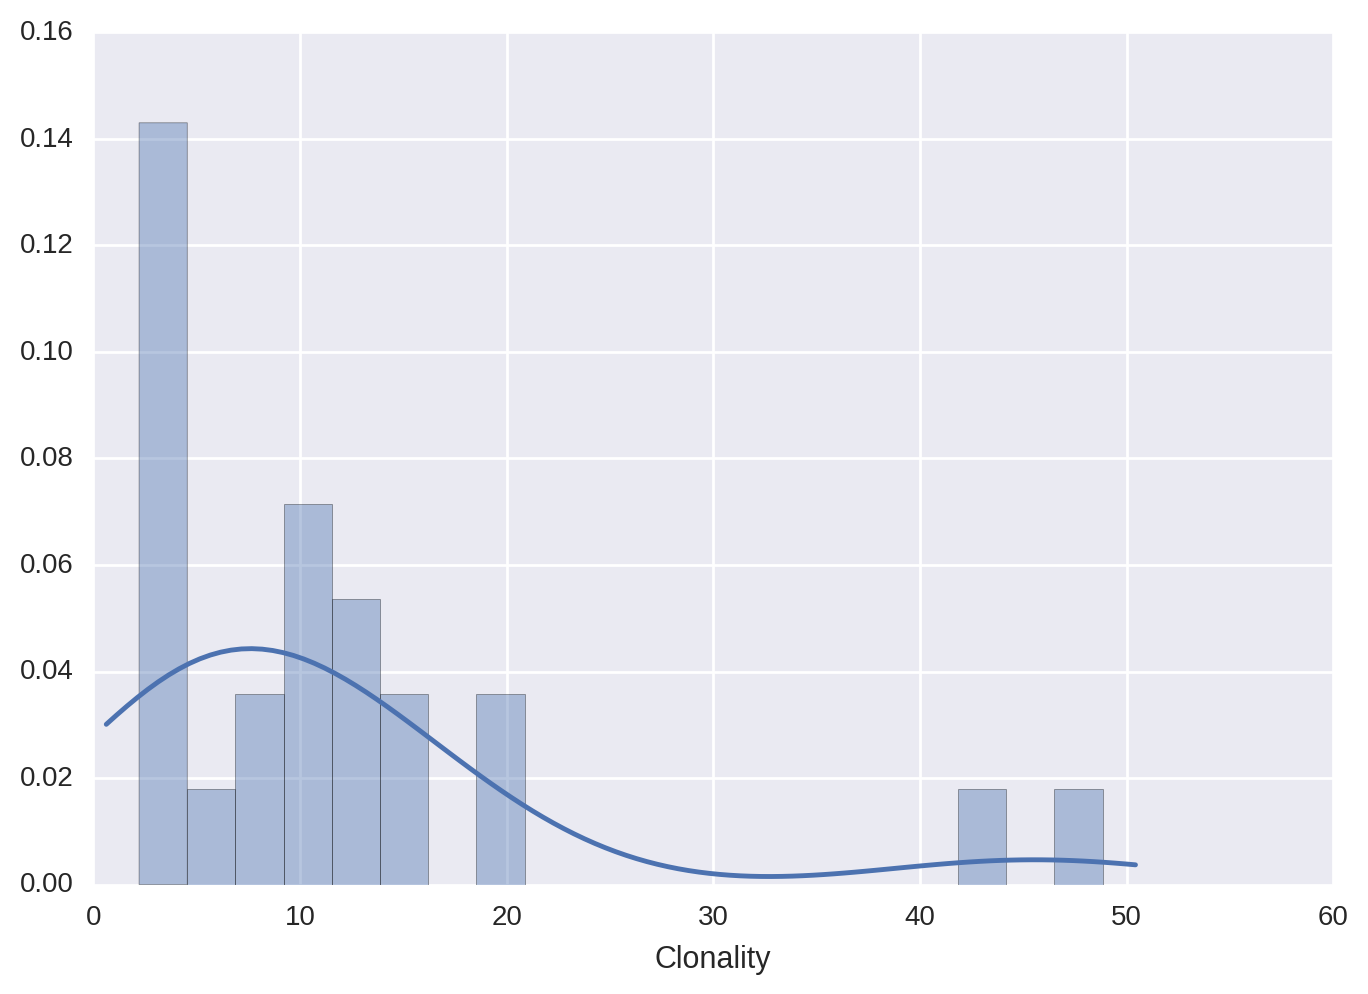

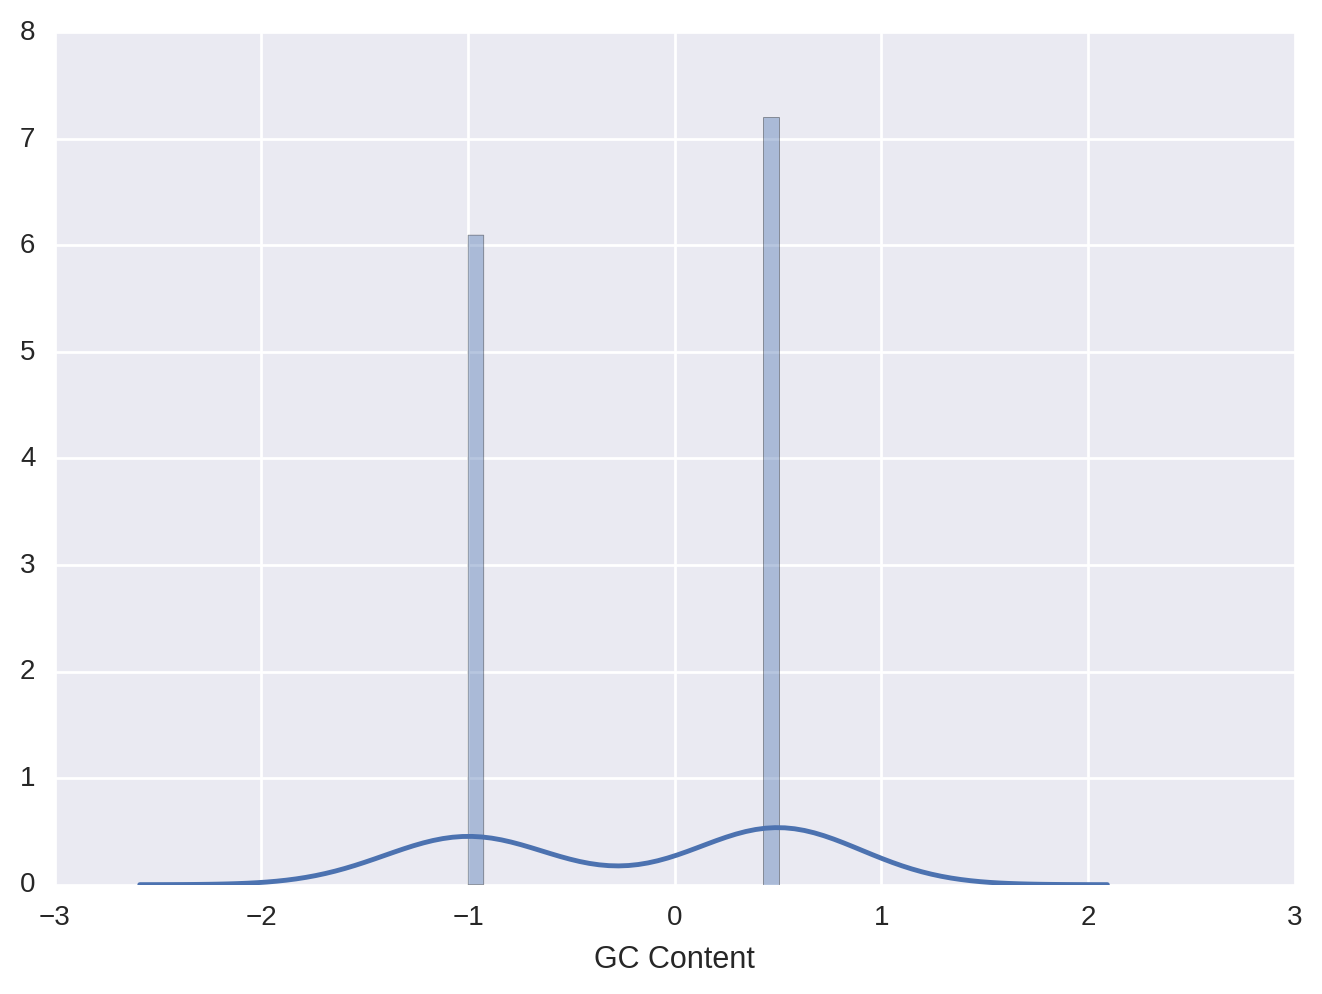

In [27]:
# plot distribution of  mapped reads
sns.distplot(summary_frame['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (Pre-filtering)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
# sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
# plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
# plt.xlabel('Total Reads')
# plt.ylabel('Frequency')
# plt.show()

# plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
# plt.xlabel('totalReads')
# plt.ylabel('uniquelyMappedReads')
# plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.show()


### Filter Samples According to Mapping Quality

In [31]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 5000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['totalReads'] >= readsThreshold]

# filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["Cell Type"].values
for simpleNameRoot in simpleTreatmentCombos:
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["sampleName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 24
Number of discarded samples: 2
Number of Samples remaining after filtering: 22


## Calculate Tag Counts and RPKM

In [32]:
%%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['sampleName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv
# !analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d $filteredTagDirectories > normed.tsv
tagDirectories = ' '.join([tagDirPath +x for x in summary_frame['sampleName']])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $tagDirectories > rpkm_all.tsv



In [33]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]


raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['sampleName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]


                                   
# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['Cell Type'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.upper())
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


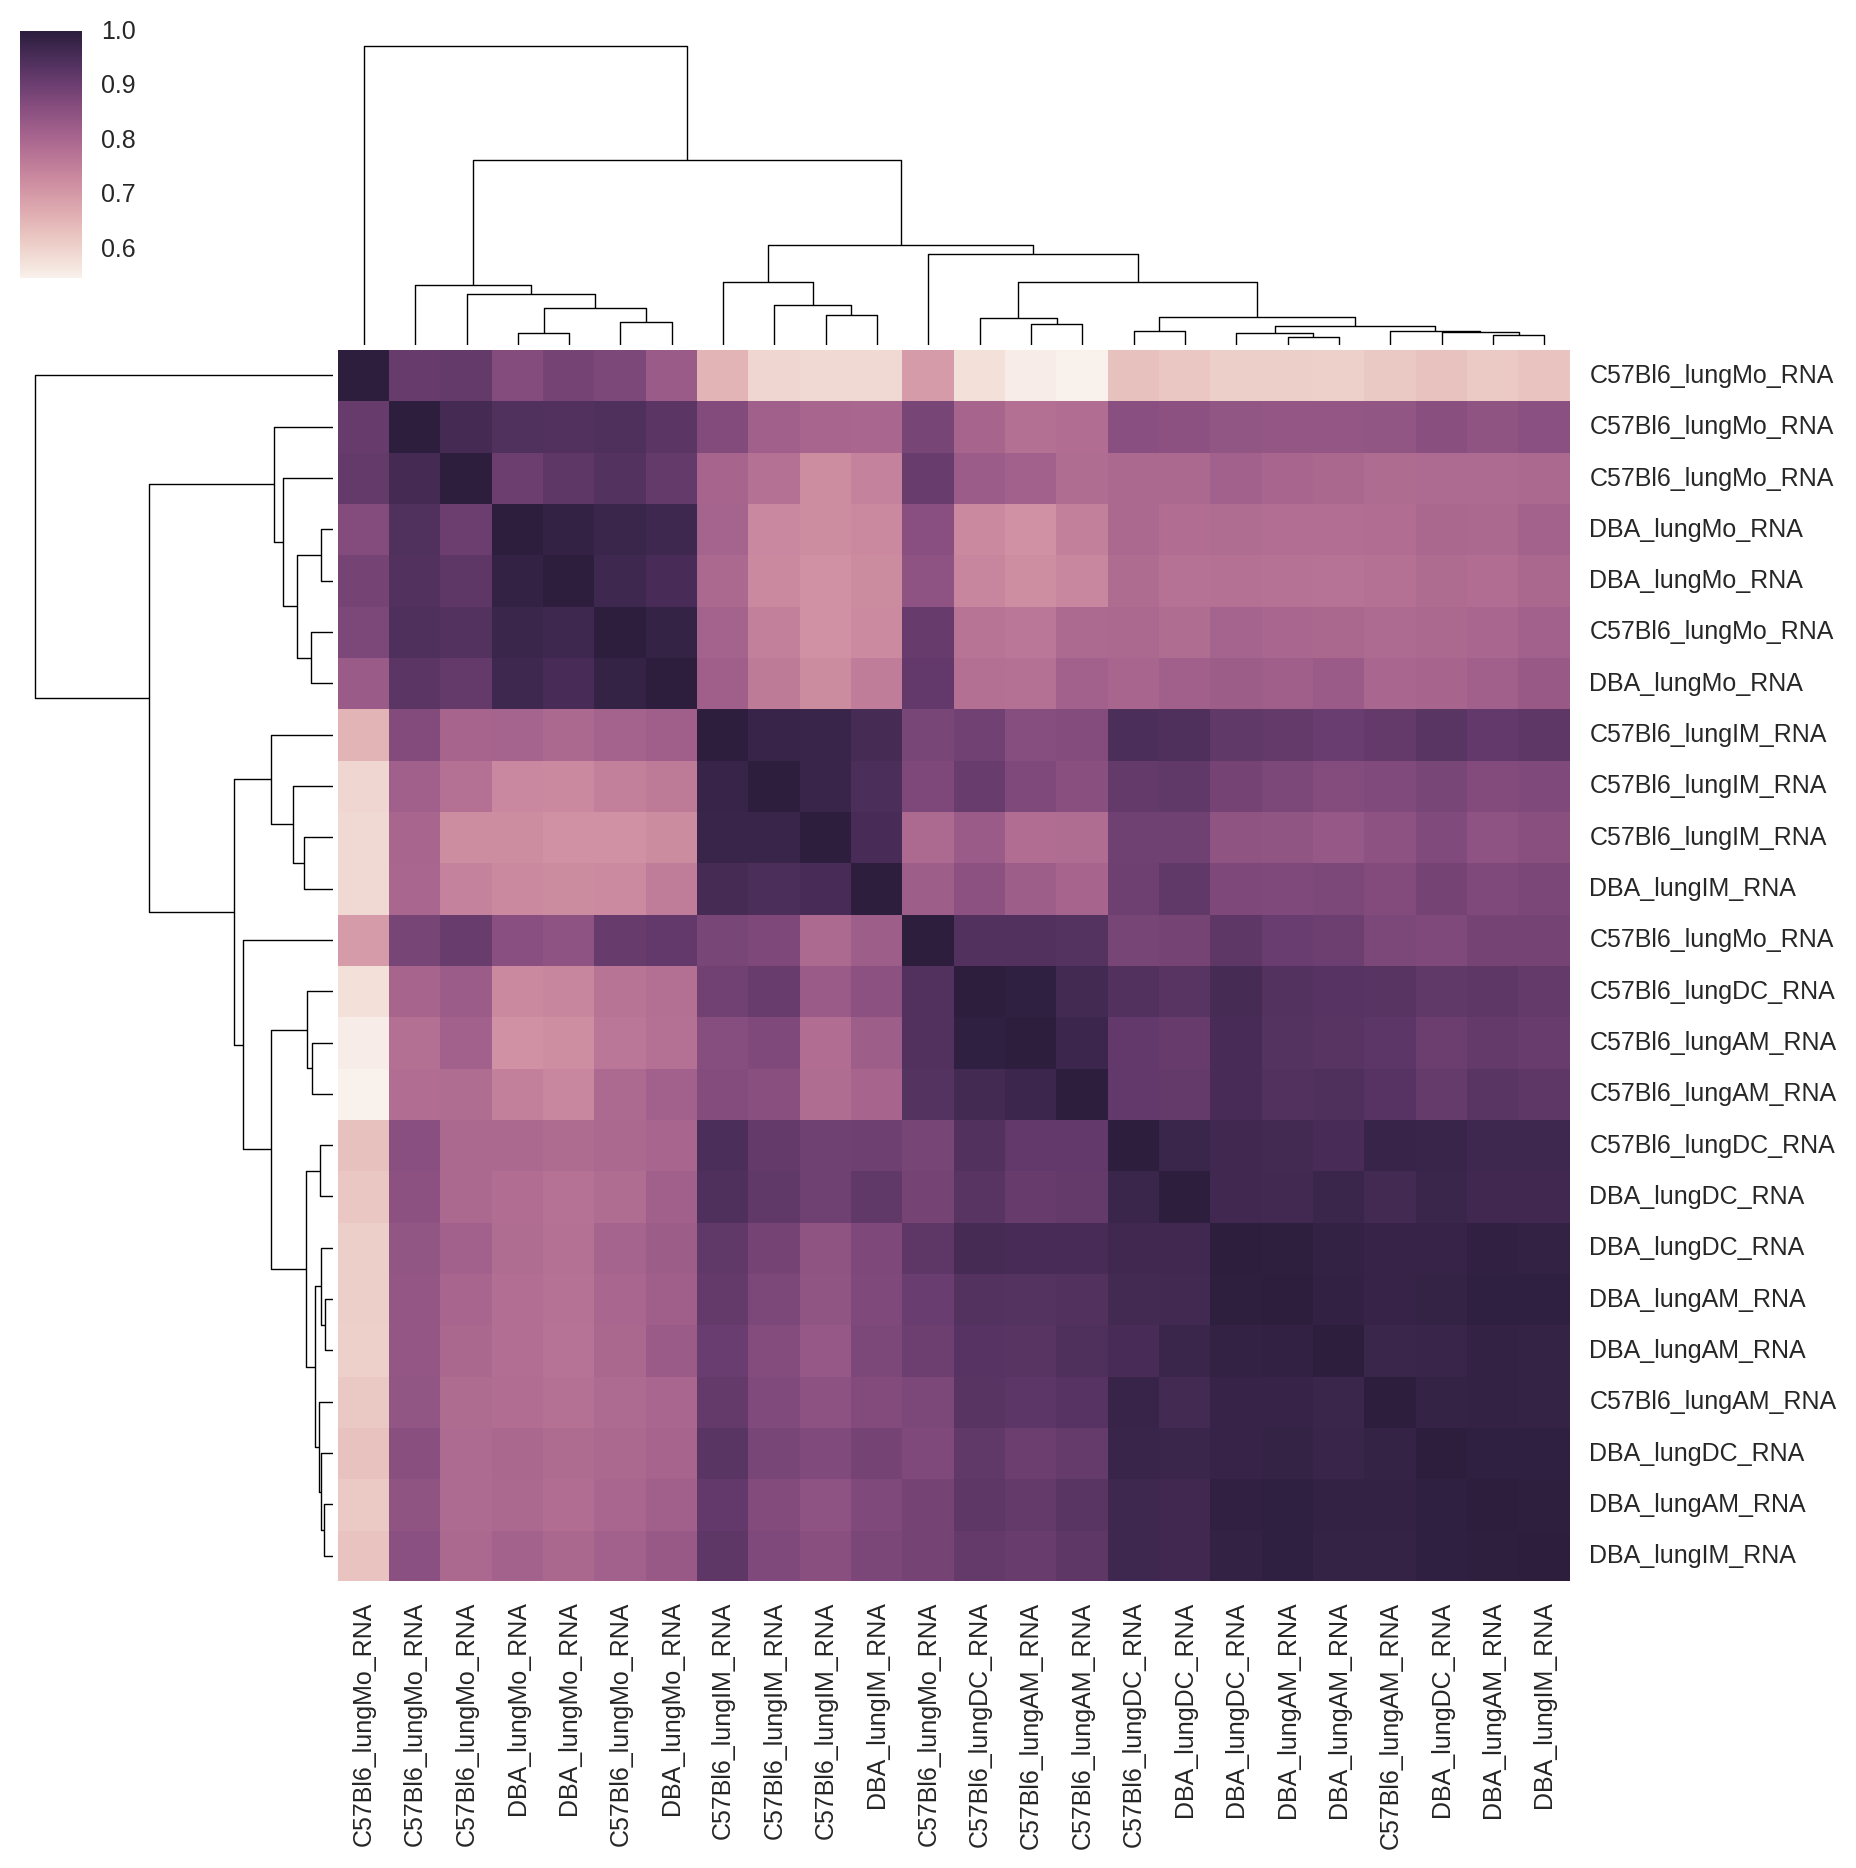

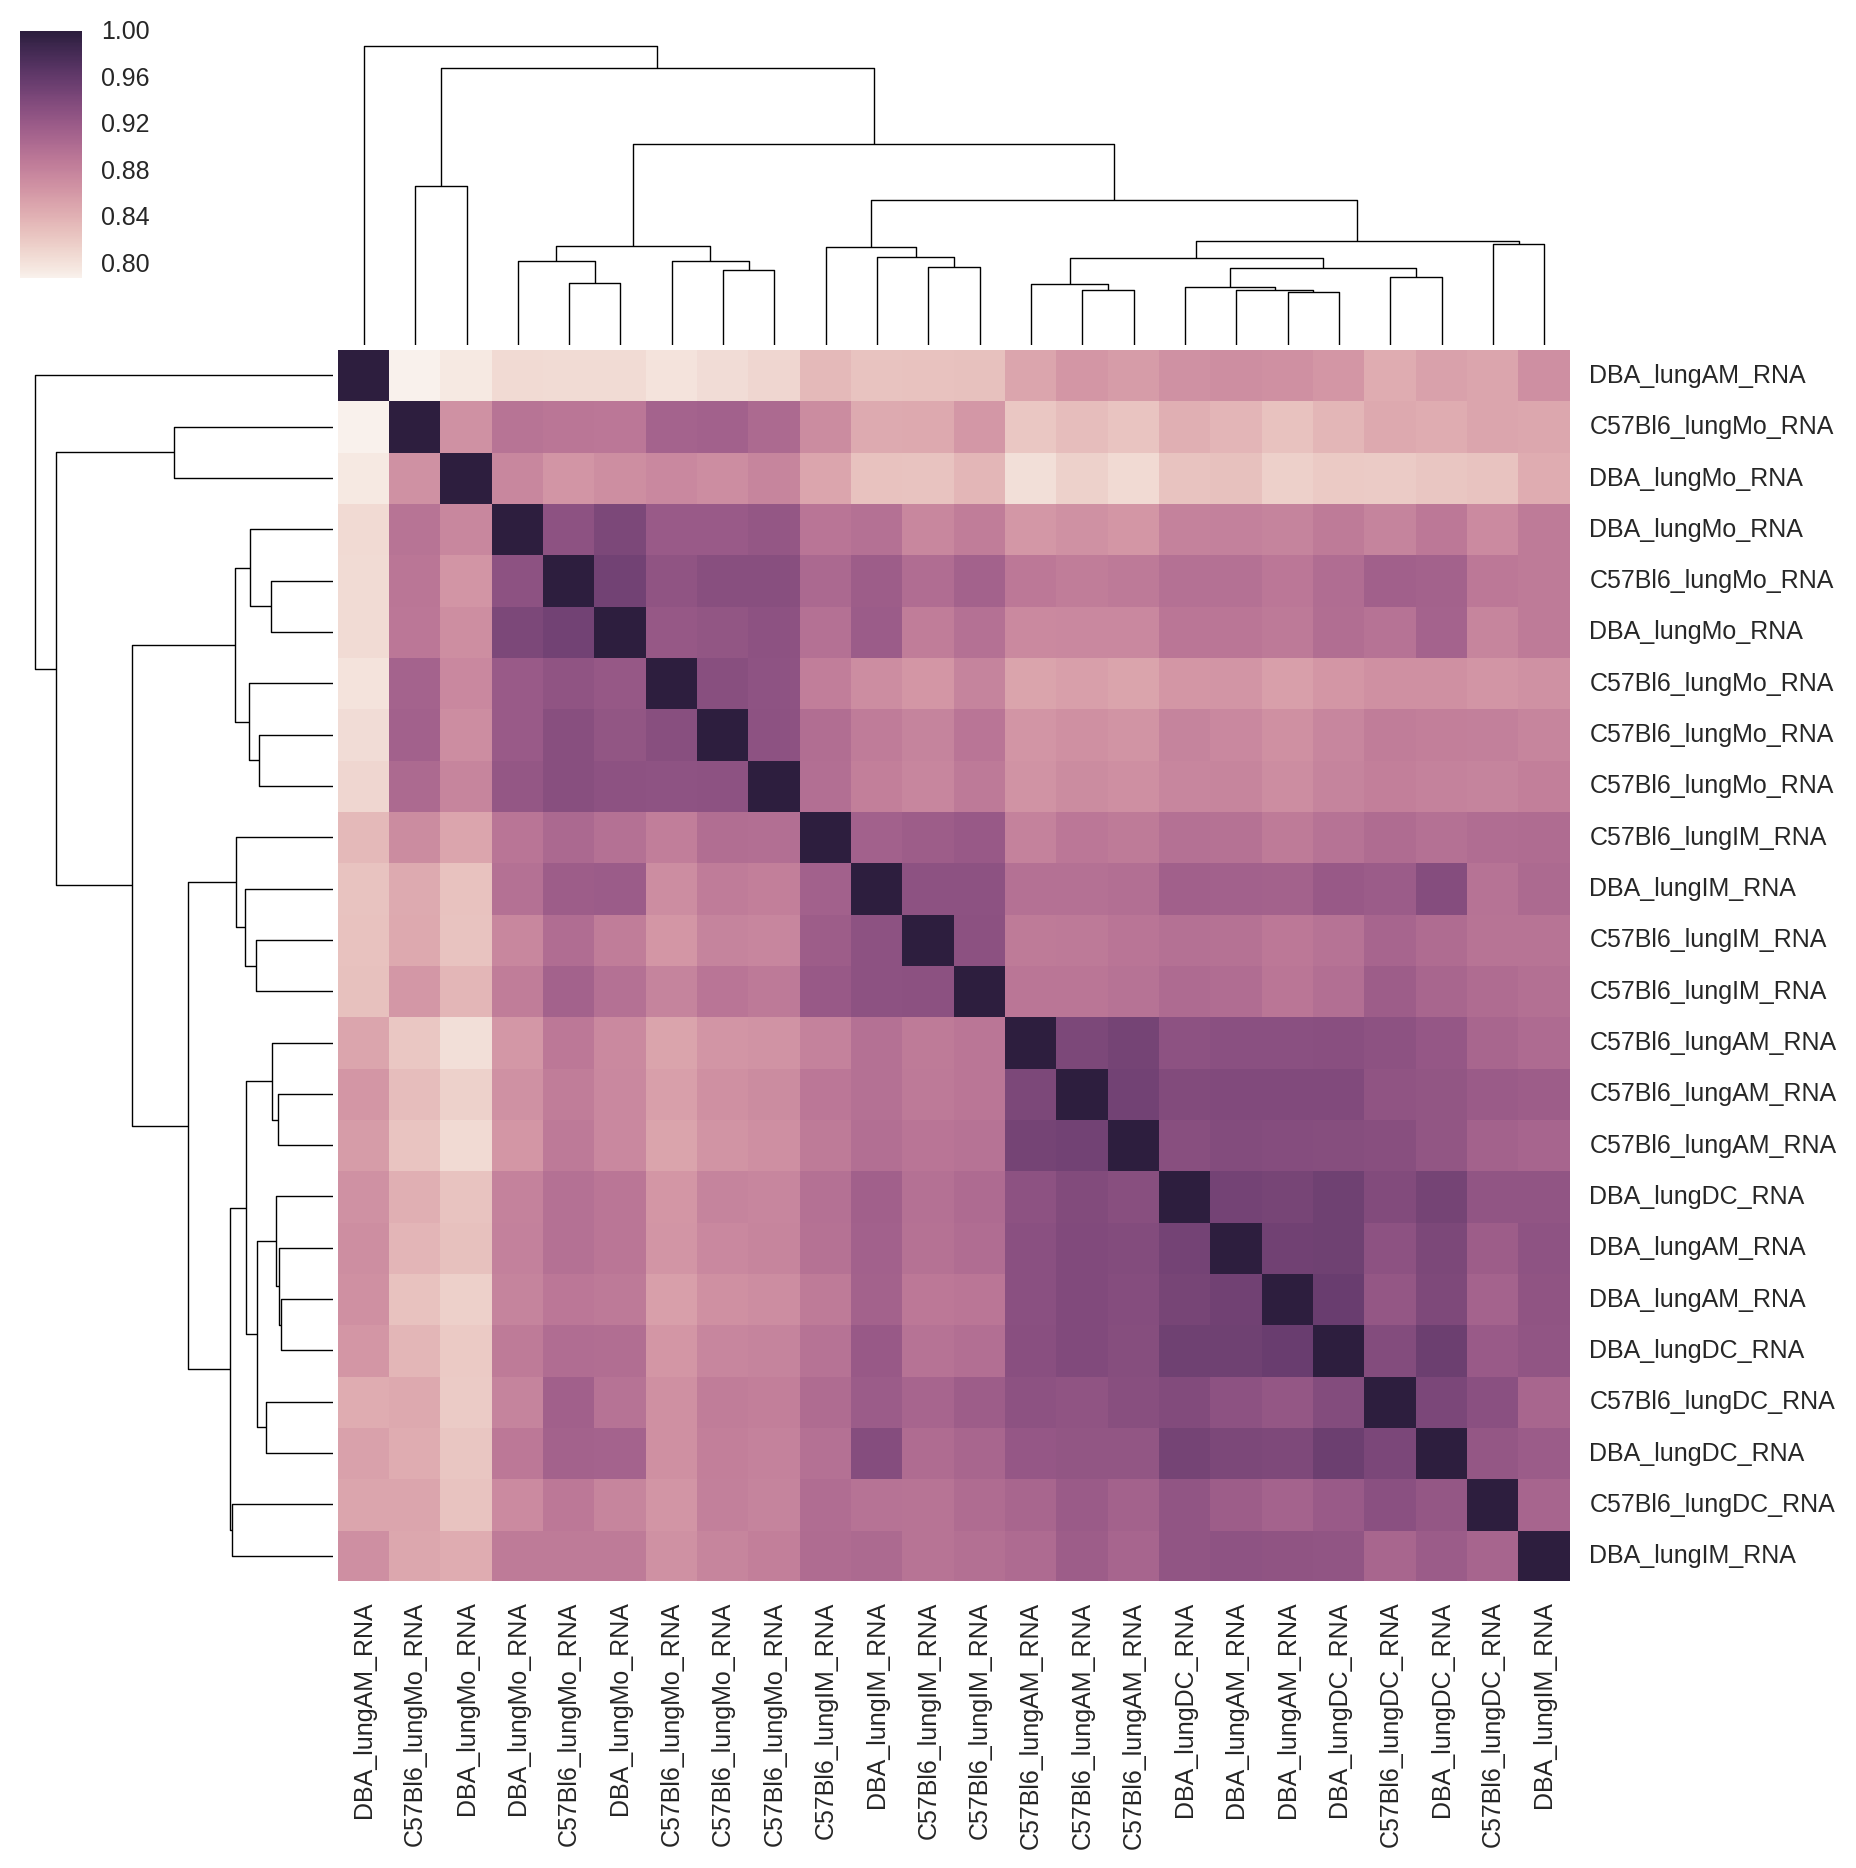

In [34]:
all_rpkm_frame = pd.read_csv("rpkm_all.tsv",sep="\t")
columns = all_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
all_rpkm_frame.columns = columns    
all_rpkm_frame['gene'] = [x.split("|")[0] for x in all_rpkm_frame['Annotation/Divergence']]
columns = list(all_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
all_rpkm_frame = all_rpkm_frame[columns]




### cluster samples according to correlation
samples = all_rpkm_frame.columns.values[9:]

labels = ['_'.join(x.split('_')[0:3]).replace('RNA_','') for x in columns[9:]]

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
for i in range(len(samples)):
    spearman_matrix[i][i]=1.0
    pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = all_rpkm_frame[samples[i]].values
        values_2 = all_rpkm_frame[samples[j]].values
        pearson, pearson_pval = scipy.stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = scipy.stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
        

sns.set_context('notebook', font_scale=0.9)
cg = sns.clustermap(pearson_matrix, xticklabels=labels, yticklabels=labels)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

cg = sns.clustermap(spearman_matrix, xticklabels=labels, yticklabels=labels)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

sns.set_context('notebook', font_scale=1.0)

In [ ]:
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
treatments = sorted(list(set(summary_frame.index)))
for i in range(len(treatments)):
    for j in range(i, len(treatments)):
        print(treatments[i], treatments[j])
        if treatments[i] == treatments[j]:
            columns = sorted(list(set(list(summary_frame.loc[treatments[i],'sampleName']) + 
                                  list(summary_frame.loc[treatments[j],'sampleName']))))
            data = np.log2(all_rpkm_frame.loc[:,columns] + 1)
            data = data[data.sum(axis=1) > 0.0]
            data.columns = ['_'.join(x.split('_')[0:2]).replace('Human-HMDM-','').replace('RNA_','') for x in columns]
            x_vars=[x for x in data.columns.values if treatments[i][1] in x]
            y_vars=[x for x in data.columns.values if treatments[j][1] in x]
            data = pd.DataFrame(data)
            print(data.shape)
            if len(x_vars) == len(y_vars):
                cg = sns.pairplot(data, 
                                  x_vars = x_vars,
                                  y_vars = y_vars
                                 )

                plt.savefig('./scatter_plots/' + '_'.join(treatments[i] + treatments[j]) + '_logRpkm.png')
                plt.close()

## Run IDR

In [ ]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['Cell Type']))
originalName_strain_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['strain']))

conditions = " ".join([originalName_strain_dict[x] + '_' + originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions &"
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

In [37]:
idr_rpkm_frame = pd.read_csv('idr/idr_union_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:2]).replace('lung','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = '_'.join(col.split('_')[0:2]).replace('lung','')
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = idr_rpkm_median_frame.sort()

## Calcuate Differential Expression with EdgeR

In [38]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['strain'] + '_'+ filtered_summary_frame['Cell Type']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x.split('/')[-1]] for x in samples])
! getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats C57Bl6_AM vs. C57Bl6_DC:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_DC vs. C57Bl6_AM: 788 (3.223%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_DC vs. C57Bl6_AM: 21 (0.086%) [log2fold<-1, FDR<0.05]
	Output Stats C57Bl6_AM vs. C57Bl6_IM:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_IM vs. C57Bl6_AM: 1569 (6.416%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_IM vs. C57Bl6_AM: 890 (3.640%) [log2fold<-1, FDR<0.05]
	Output Stats C57Bl6_AM vs. C57Bl6_Mo:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_Mo vs. C57Bl6_AM: 2389 (9.770%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_Mo vs. C57Bl6_AM: 2308 (9.439%) [log2fold<-1, FDR<0.05]
	Output Stats C57Bl6_AM vs. DBA_AM:
		Total Genes: 24453
		Total Up-regulated in DBA_AM vs. C57Bl6_AM: 385 (1.574%) [log2fold>1

In [49]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [67]:
!rm gene_ontology/*

treatment_up_dict = {}
treatment_down_dict = {}

if not os.path.isdir('gene_ontology'):
    os.mkdir('gene_ontology')
    
fdr_threshold = 0.05

fdrColumns = [x for x in diffExpression_frame.columns if 'adj.' in x]

treatments = sorted([x.replace('lung','') for x in idr_rpkm_mean_frame.columns.values])
treatment_index_dict = dict(zip(treatments, range(len(treatments))))

numTreatments = len(treatment_index_dict.keys())
up_matrix=np.zeros((numTreatments,numTreatments))
down_matrix=np.zeros((numTreatments,numTreatments))
for c in fdrColumns:
    tokens = c.split()
    treatment1 = tokens[0]
    treatment2 = tokens[2]

    fc_column = c.replace('adj. p-value', 'Log2 Fold Change')
    current_frame = diffExpression_frame[diffExpression_frame[c] < fdr_threshold][[c, fc_column, 'gene']]

    up_genes = current_frame[current_frame[fc_column] > np.log2(2)]['gene'].values
    down_genes = current_frame[current_frame[fc_column] < -np.log2(2)]['gene'].values

    # use genes that pass through IDR only
    idr_genes = idr_rpkm_mean_frame.index.values
    up_genes = [x for x in up_genes if x.upper() in idr_genes]
    down_genes = [x for x in down_genes if x.upper() in idr_genes]

    print(treatment1, treatment2, len(up_genes), len(down_genes))
    ind1 = treatment_index_dict[treatment1]
    ind2 = treatment_index_dict[treatment2]
    
    up_matrix[ind1][ind2] = int(len(up_genes))
    up_matrix[ind2][ind1] = int(len(up_genes))
    
    down_matrix[ind1][ind2] = int(len(down_genes))
    down_matrix[ind2][ind1] = int(len(down_genes))
    
    up_file = open('./gene_ontology/'+treatment1+'_'+treatment2+'_up_genes.txt','w')
    down_file = open('./gene_ontology/'+treatment1+'_'+treatment2+'_down_genes.txt','w')
    
    for g in up_genes:
        up_file.write(g.upper()+'\n')
    up_file.close()
    
    for g in down_genes:
        down_file.write(g.upper()+'\n')
    down_file.close()
up_frame = pd.DataFrame(up_matrix)
up_frame.index = treatments
up_frame.columns = treatments

down_frame = pd.DataFrame(down_matrix)
down_frame.index = treatments
down_frame.columns = treatments

rm: cannot remove ‘gene_ontology/*’: No such file or directory
C57Bl6_AM C57Bl6_DC 785 21
C57Bl6_AM C57Bl6_IM 1568 889
C57Bl6_AM C57Bl6_Mo 2383 2301
C57Bl6_AM DBA_AM 385 354
C57Bl6_AM DBA_DC 772 345
C57Bl6_AM DBA_IM 918 226
C57Bl6_AM DBA_Mo 2692 2375
C57Bl6_DC C57Bl6_IM 680 500
C57Bl6_DC C57Bl6_Mo 1625 1402
C57Bl6_DC DBA_AM 266 645
C57Bl6_DC DBA_DC 195 247
C57Bl6_DC DBA_IM 180 99
C57Bl6_DC DBA_Mo 1859 1358
C57Bl6_IM C57Bl6_Mo 1310 1626
C57Bl6_IM DBA_AM 813 1253
C57Bl6_IM DBA_DC 849 1139
C57Bl6_IM DBA_IM 51 41
C57Bl6_IM DBA_Mo 1403 1048
C57Bl6_Mo DBA_AM 1981 1993
C57Bl6_Mo DBA_DC 2299 2040
C57Bl6_Mo DBA_IM 1249 1221
C57Bl6_Mo DBA_Mo 171 78
DBA_AM DBA_DC 160 3
DBA_AM DBA_IM 327 0
DBA_AM DBA_Mo 2271 1875
DBA_DC DBA_IM 298 19
DBA_DC DBA_Mo 2183 2058
DBA_IM DBA_Mo 668 449


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Text xticklabel objects>)

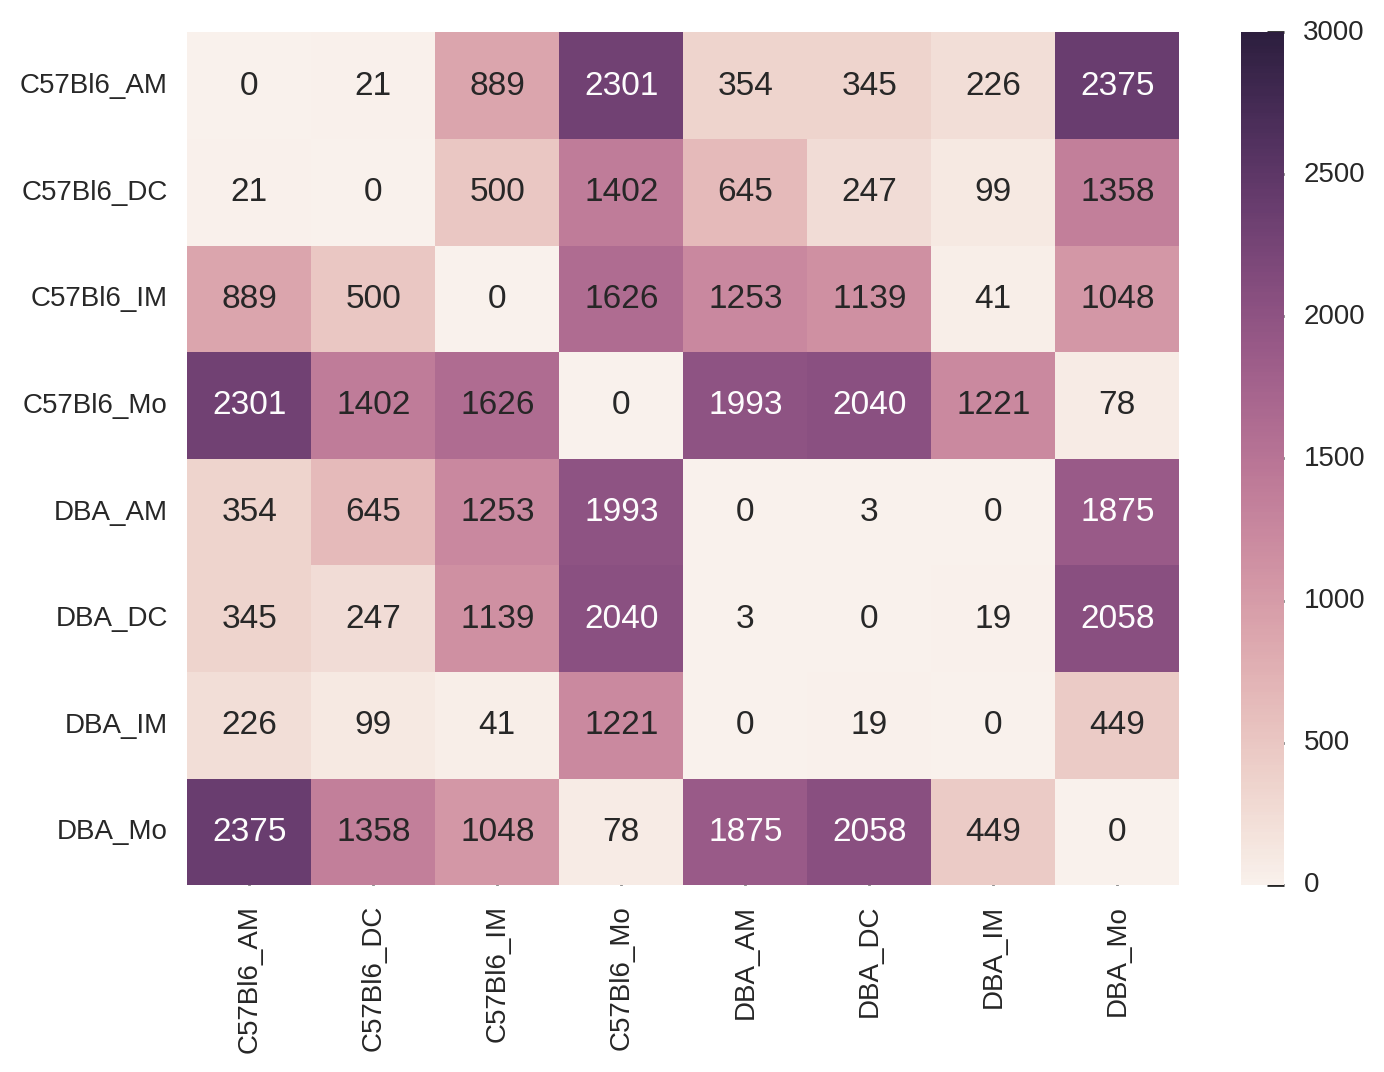

In [61]:
data = down_frame[['C57Bl6_AM',
 'C57Bl6_DC',
 'C57Bl6_IM',
 'C57Bl6_Mo',
 'DBA_AM',
 'DBA_DC',
 'DBA_IM',
 'DBA_Mo'
 ]]
data = data[data.index.isin(['C57Bl6_AM',
 'C57Bl6_DC',
 'C57Bl6_IM',
 'C57Bl6_Mo',
 'DBA_AM',
 'DBA_DC',
 'DBA_IM',
 'DBA_Mo'
 ])]
cg = sns.heatmap(data,vmax=3000, annot=True,fmt="g")
plt.xticks(rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Text xticklabel objects>)

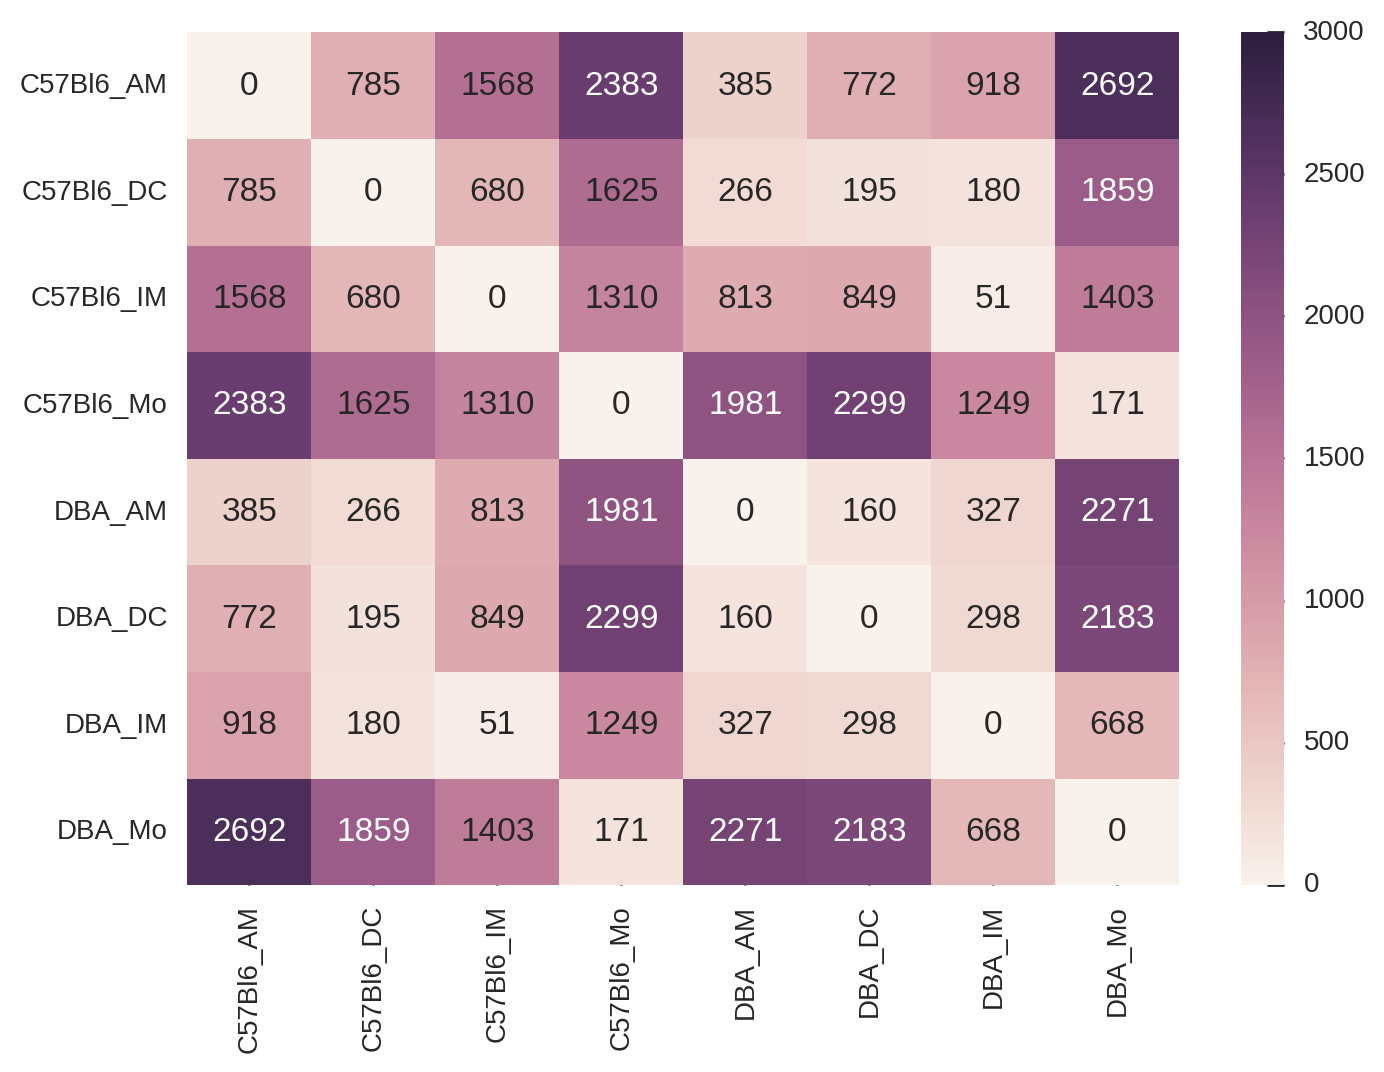

In [62]:
data = up_frame[['C57Bl6_AM',
 'C57Bl6_DC',
 'C57Bl6_IM',
 'C57Bl6_Mo',
 'DBA_AM',
 'DBA_DC',
 'DBA_IM',
 'DBA_Mo'
 ]]
data = data[data.index.isin(['C57Bl6_AM',
 'C57Bl6_DC',
 'C57Bl6_IM',
 'C57Bl6_Mo',
 'DBA_AM',
 'DBA_DC',
 'DBA_IM',
 'DBA_Mo'
 ])]
cg = sns.heatmap(data,vmax=3000, annot=True,fmt="g")
plt.xticks(rotation=90)

## Gene Ontology Enrichment

In [68]:
outFile = open('./gene_ontology/background.txt', 'w')
for g in raw_frame[raw_frame.ix[:,9:].sum(axis=1) > 16.0]['gene'].values:
    outFile.write(g.upper() + '\n')
outFile.close()

for f in os.listdir('./gene_ontology/'):
    if not 'background' in f and not 'result' in f and 'txt' in f:
        out_name = f.replace('.txt', '_result.txt')
        os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt /home/jenhan/analysis/go_analysis/mouse_association --pval=0.05 > ./gene_ontology/' + out_name)
        print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name + ' &')




/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/C57Bl6_DC_C57Bl6_IM_down_genes.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/C57Bl6_DC_C57Bl6_IM_down_genes_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/C57Bl6_Mo_DBA_DC_up_genes.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/C57Bl6_Mo_DBA_DC_up_genes_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/C57Bl6_Mo_DBA_IM_up_genes.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/C57Bl6_Mo_DBA_IM_up_genes_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/C57Bl6_AM_DBA_AM_down_genes.txt ./gene_ontology/ba

In [44]:
fdr_threshold = 0.05
p_threshold = 0.05
term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
    if 'result' in f and 'up' in f and 'txt' in f :
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_uncorrected'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_uncorrected'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
up_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
up_frame['id'] = [term_id_dict[x] for x in up_frame.index.values]


term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
    if 'result' in f and 'down' in f:
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_uncorrected'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_uncorrected'].values,  
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)

term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
down_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
down_frame['id'] = [term_id_dict[x] for x in down_frame.index.values]

up_frame=up_frame[[x for x in  up_frame.columns if not '30' in x]]
down_frame=down_frame[[x for x in  down_frame.columns if not '30' in x]]

# save go terms
up_frame.to_csv('go_terms_up.tsv', sep='\t')
down_frame.to_csv('go_terms_down.tsv', sep='\t')
out_file = open('go_ids_up.txt', 'w')
for id in up_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

out_file = open('go_ids_down.txt', 'w')
for id in down_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

## Tag Scatter Plots

rm: cannot remove ‘./scatter_plots/*’: No such file or directory
C57Bl6_DC C57Bl6_AM
ERROR! Session/line number was not unique in database. History logging moved to new session 506


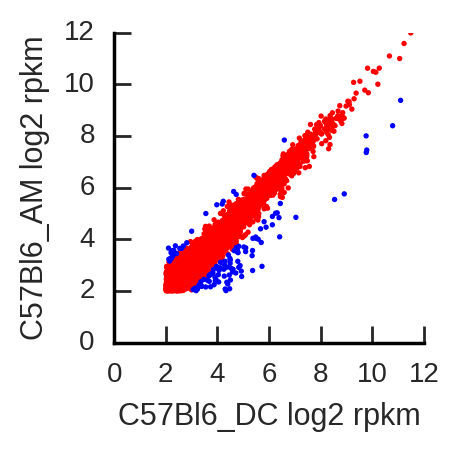

C57Bl6_IM C57Bl6_AM


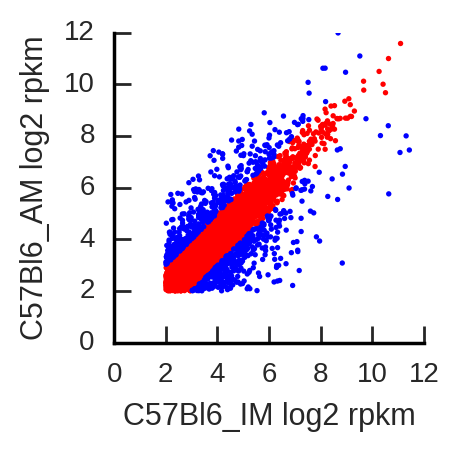

C57Bl6_Mo C57Bl6_AM


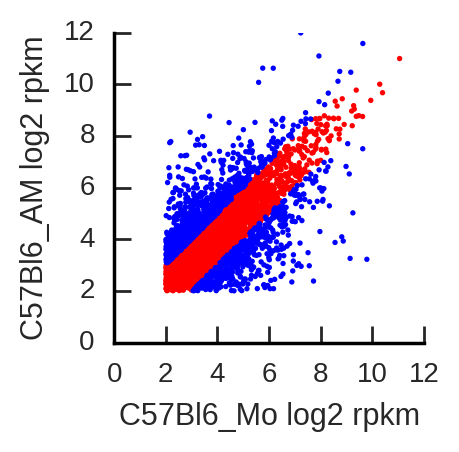

DBA_AM C57Bl6_AM


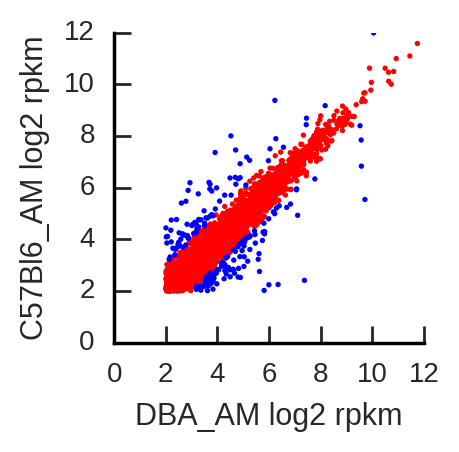

DBA_DC C57Bl6_AM


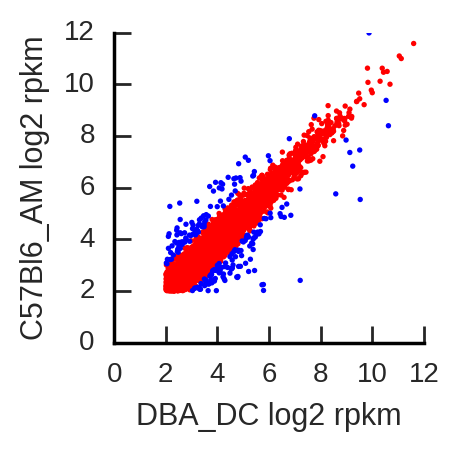

DBA_IM C57Bl6_AM


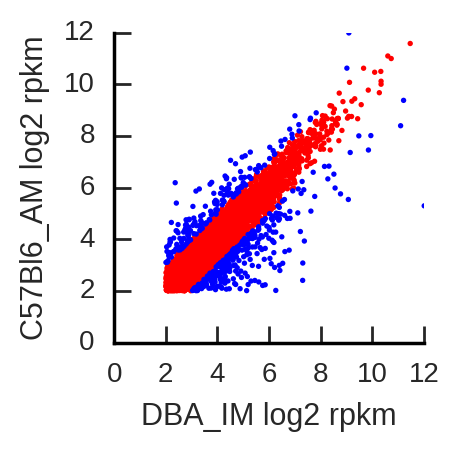

DBA_Mo C57Bl6_AM


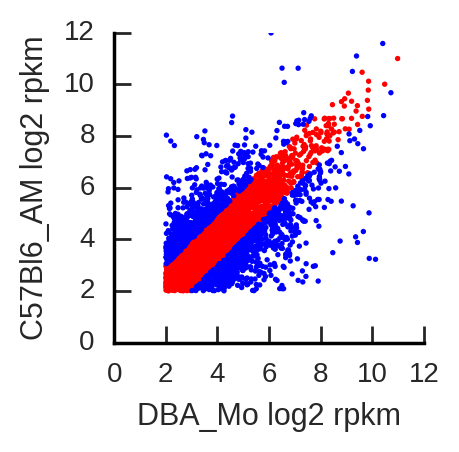

C57Bl6_IM C57Bl6_DC


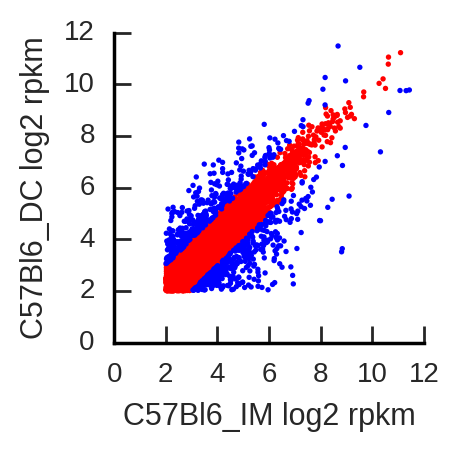

C57Bl6_Mo C57Bl6_DC


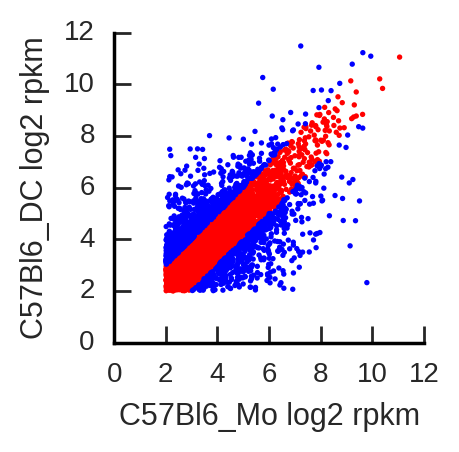

DBA_AM C57Bl6_DC


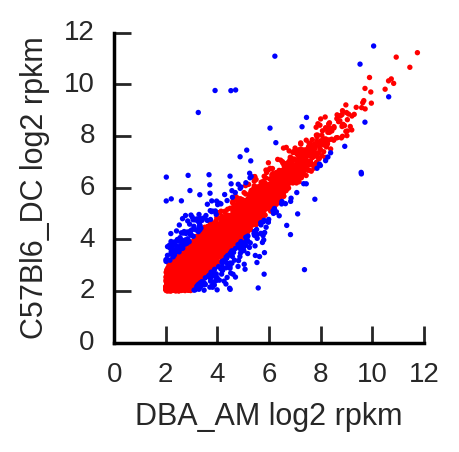

DBA_DC C57Bl6_DC


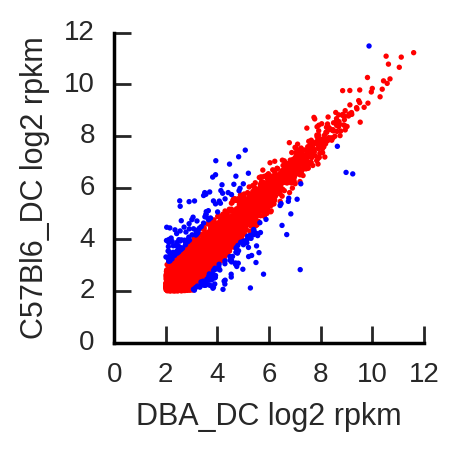

DBA_IM C57Bl6_DC


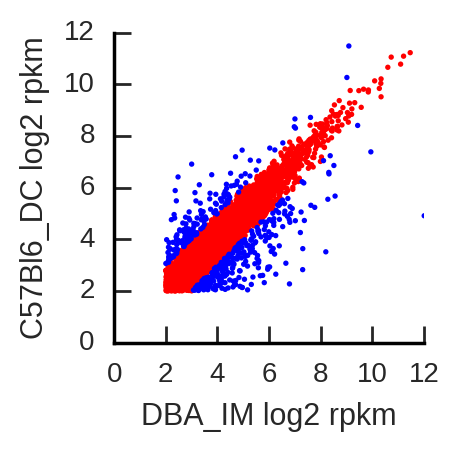

DBA_Mo C57Bl6_DC


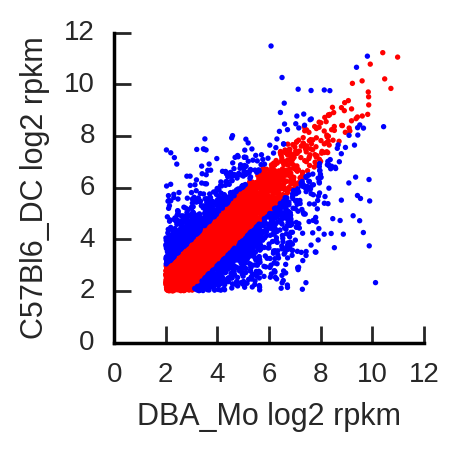

C57Bl6_Mo C57Bl6_IM


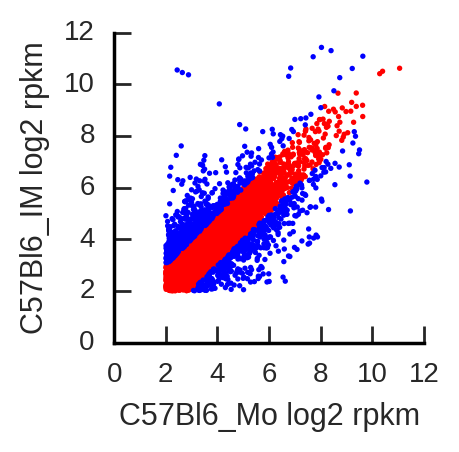

DBA_AM C57Bl6_IM


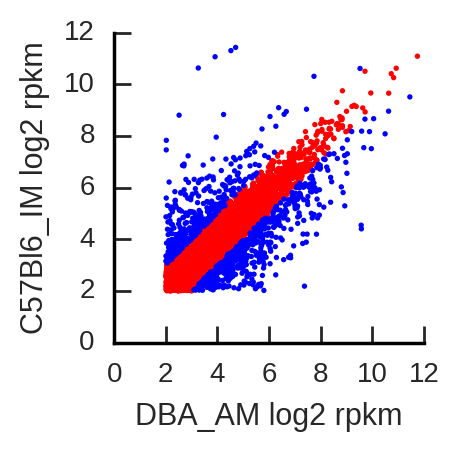

DBA_DC C57Bl6_IM


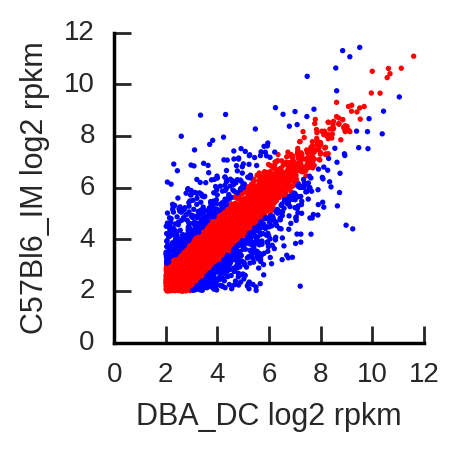

DBA_IM C57Bl6_IM


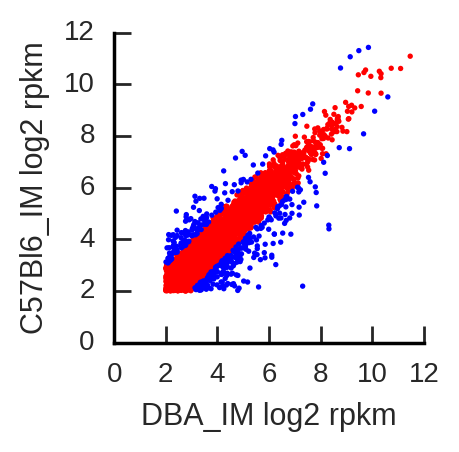

DBA_Mo C57Bl6_IM


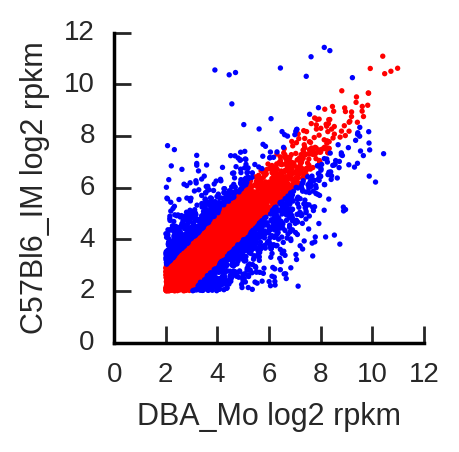

DBA_AM C57Bl6_Mo


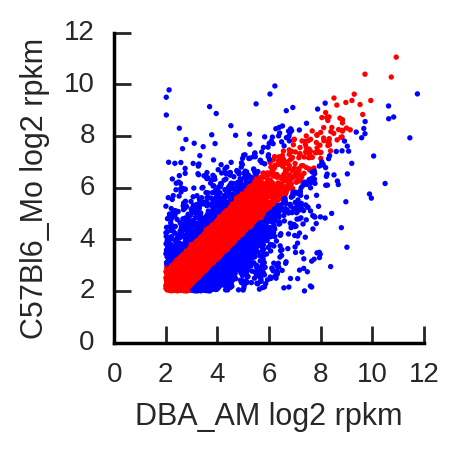

DBA_DC C57Bl6_Mo


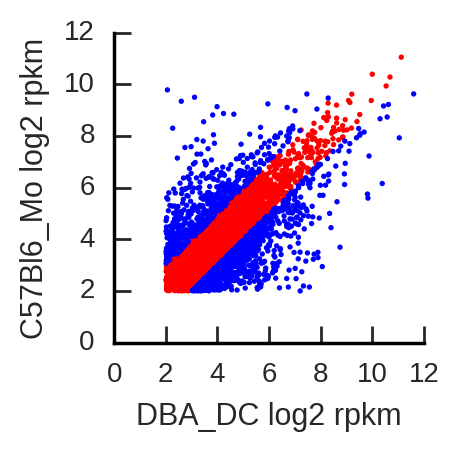

DBA_IM C57Bl6_Mo


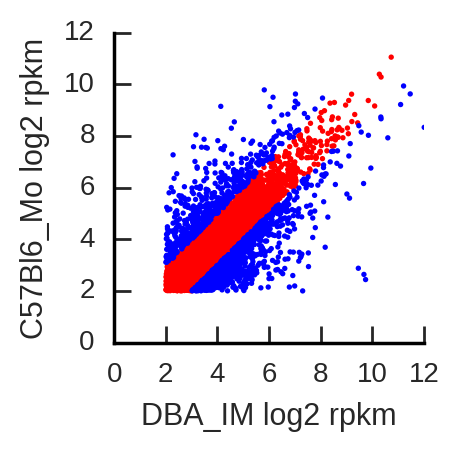

DBA_Mo C57Bl6_Mo


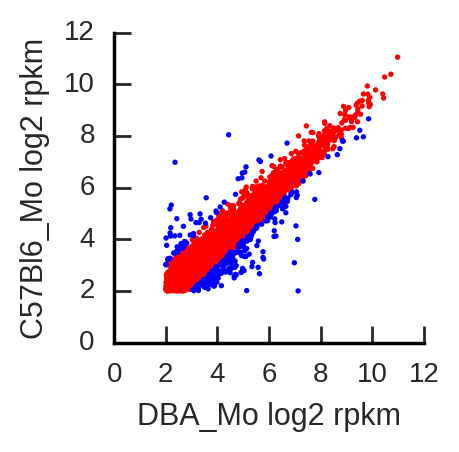

DBA_DC DBA_AM


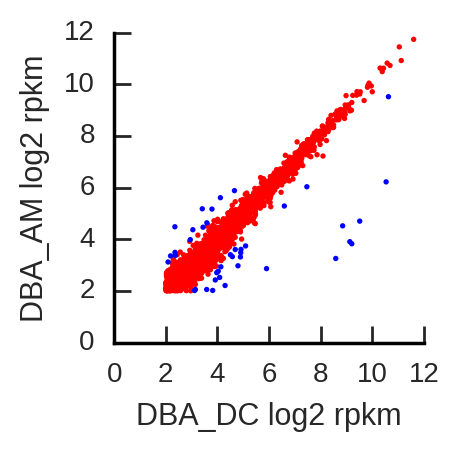

DBA_IM DBA_AM


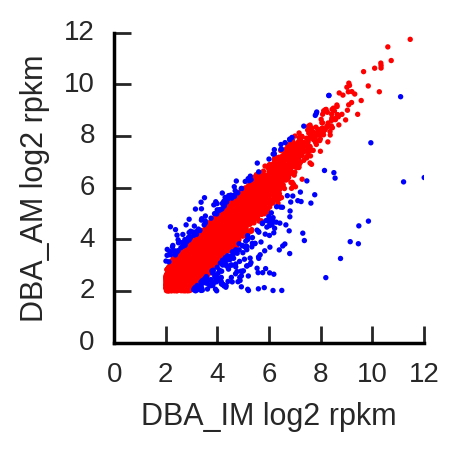

DBA_Mo DBA_AM


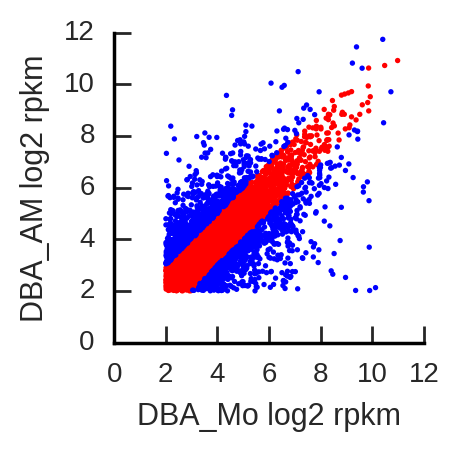

DBA_IM DBA_DC


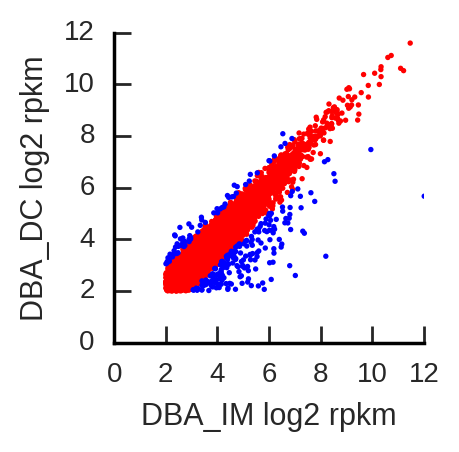

DBA_Mo DBA_DC


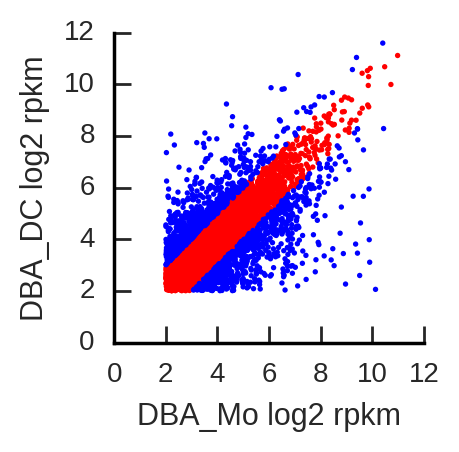

DBA_Mo DBA_IM


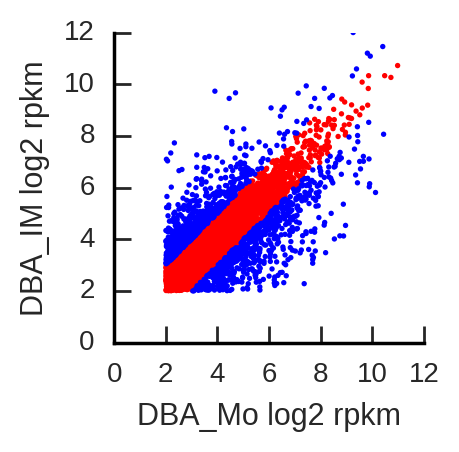

In [69]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

! rm ./scatter_plots/*

target_genes = [
# 'DHCR24'
# 'FASN',
# 'SREBF1',
# 'SREBF2',
# 'SCD1',
# 'SCD2',
# 'HMGCR',
# 'ABCA1',
# 'ABCG1',
# 'IDOL',
# 'LDLR',
# 'ACCA' ,
# 'Acc1',
# 'ACCB',
# 'Acc2',
# 'LPL',
# 'CETP',
# 'ABCG5',
# 'ABCG8',
# 'PLTP',
# 'INSIG1'
]
target_genes = [x.upper() for x in target_genes]

if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0
   
fdrColumns = [x for x in diffExpression_frame.columns if 'adj.' in x]


for c in fdrColumns:
        tokens = c.split()

        treatment1 = tokens[2]
        treatment2 = tokens[0]
        print(treatment1, treatment2)

        fc_column = c.replace('adj. p-value', 'Log2 Fold Change')

        diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

       
        reads1 = idr_rpkm_mean_frame[treatment1]
        reads2 = idr_rpkm_mean_frame[treatment2]

        all_genes = [refseq_gene_mapping[x] for x in filtered_rpkm_frame.index.values]
        read_tuple_list = tuple(zip(all_genes, reads1, reads2))
        filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff and x[2]>= rpkm_cutoff ]

        filtered_genes = [x[0] for x in filtered_read_tuple_list]
        reads1 = np.array([x[1] for x in filtered_read_tuple_list])
        reads2 = np.array([x[2] for x in filtered_read_tuple_list])
         # log values
        logged_reads1 = np.log2(reads1 + 0.01)
        logged_reads2 = np.log2(reads2 + 0.01)

        label_x = []
        label_y = []
        fold_genes = []
        for i in range(len(filtered_genes)): 
            fold = (reads1[i]+0.000001)/(reads2[i]+0.0000001)
            if fold >=fold_threshold or fold <=1/fold_threshold:
                fold_genes.append(filtered_genes[i])
                label_x.append(logged_reads1[i])
                label_y.append(logged_reads2[i])

#             colors = ['blue' if x in diff_genes and x in fold_genes else 'grey' if x in fold_genes else 'lightgrey' for x in idr_rpkm_frame.index.values]
#         colors = ['blue' if x in diff_genes or x in fold_genes else 'red' for x in filtered_genes]
        colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


        # ensure diff diff expressed genes are on top
        val_tuples = tuple(zip(logged_reads1,logged_reads2,colors))
        sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
        logged_reads1 = [x[0] for x in sorted_tuples] 
        logged_reads2 = [x[1] for x in sorted_tuples]
        colors = [x[2] for x in sorted_tuples]
        plt.figure(figsize=(2,2))
        plt.scatter(logged_reads1, logged_reads2, edgecolors='none', c=colors, marker = '.', s=15)
        ### annotate differentially expressed genes
        offset = -1
        for label, x, y in zip(fold_genes, label_x, label_y):
            if label.upper() in target_genes:
                if x < y:
                    plt.annotate(
                        label, 
                        xy = (x, y),
                        size=4)

                else:
                    plt.annotate(
                        label, 
                        xy = (x, y),
                        size=4)
            if offset == 1:
                offset=-1
            else: 
                offset = 1
        sns.despine()
        # fix aspect ratio
        ax = plt.gca()
        ax.set_xlim((0,12))
        ax.set_ylim((0,12))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
        plt.xlabel(treatment1 + ' log2 rpkm')
        plt.ylabel(treatment2 + ' log2 rpkm')
#         plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.png', bbox_inches='tight')
        plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
        plt.show()
            
        

## PCA Analysis

In [59]:
markerDict

{'C57Bl6_AM': 'd',
 'C57Bl6_DC': '*',
 'C57Bl6_IM': 'p',
 'C57Bl6_Mo': '^',
 'DBA_AM': 's',
 'DBA_DC': '.',
 'DBA_IM': 'o'}

num down 6627 num up 6492


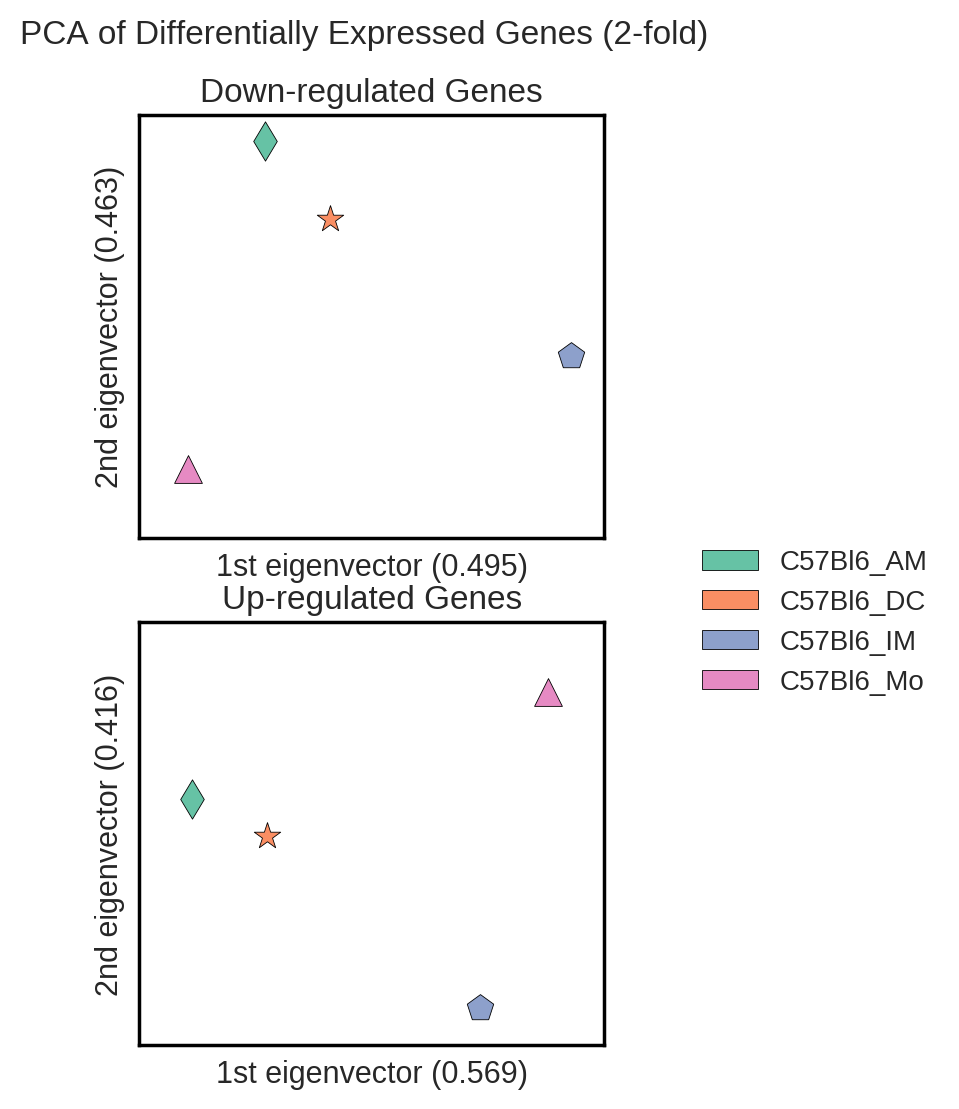

In [85]:
### for up-regulated genes
from matplotlib import patches as mpatches
classes = ['C57Bl6_AM','C57Bl6_DC','C57Bl6_IM', 'C57Bl6_Mo']#, 'DBA_AM', 'DBA_Mo', 'DBA_DC', 'DBA_IM']


markerDict = dict(zip(sorted(set(classes)), 
                 ['d','*','p','^','s','.','o','>']))
colorDict = dict(zip(sorted(set(idr_rpkm_mean_frame.columns.values)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))

fdr_threshold = 0.01

fold_threshold = np.log2(2)
fdr_cols = [x for x in diffExpression_frame.columns if 'adj. p-value' in x]
fold_cols = [x for x in diffExpression_frame.columns if 'Log2 Fold Change' in x]

down_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].max(axis=1) >= fold_threshold)
                                 ]['gene'].values
down_diff_genes = [x.upper() for x in down_diff_genes]

up_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].min(axis=1) <= -1*fold_threshold)
                                 ]['gene'].values
up_diff_genes = [x.upper() for x in up_diff_genes]

print('num down', len(down_diff_genes), 'num up', len(up_diff_genes))
f, axs = plt.subplots(2,1, figsize=(3,6))
plt.suptitle('PCA of Differentially Expressed Genes (2-fold)')

### down_regulated genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(down_diff_genes)][classes]
markers = [markerDict[x] for x in features.columns.values]
colors = [colorDict[x] for x in features.columns.values]

down_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = down_model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

plt.subplot(2,1,1)  
for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], marker=markers[i], s=100, c=colors[i])

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Down-regulated Genes')

### up-regulatd genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(up_diff_genes)][classes]
markers = [markerDict[x] for x in features.columns.values]
colors = [colorDict[x] for x in features.columns.values]

up_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = up_model.fit_transform(features.T)
explained_variance_ratios = up_model.explained_variance_ratio_

plt.subplot(2,1,2)  
for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], marker=markers[i], s=100, c=colors[i])

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Up-regulated Genes')

# # legend
classes = [x for x in classes if not '30' in x]
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.75, 1.0))
plt.savefig('pca_adult.pdf',bbox_inches='tight')

plt.show()



## Heatmap

In [63]:
from sklearn.cluster import KMeans

In [73]:
features.columns.values

array(['DBA_IM', 'C57Bl6_Mo', 'DBA_AM', 'C57Bl6_AM', 'C57Bl6_IM', 'DBA_DC',
       'DBA_Mo', 'C57Bl6_DC'], dtype=object)

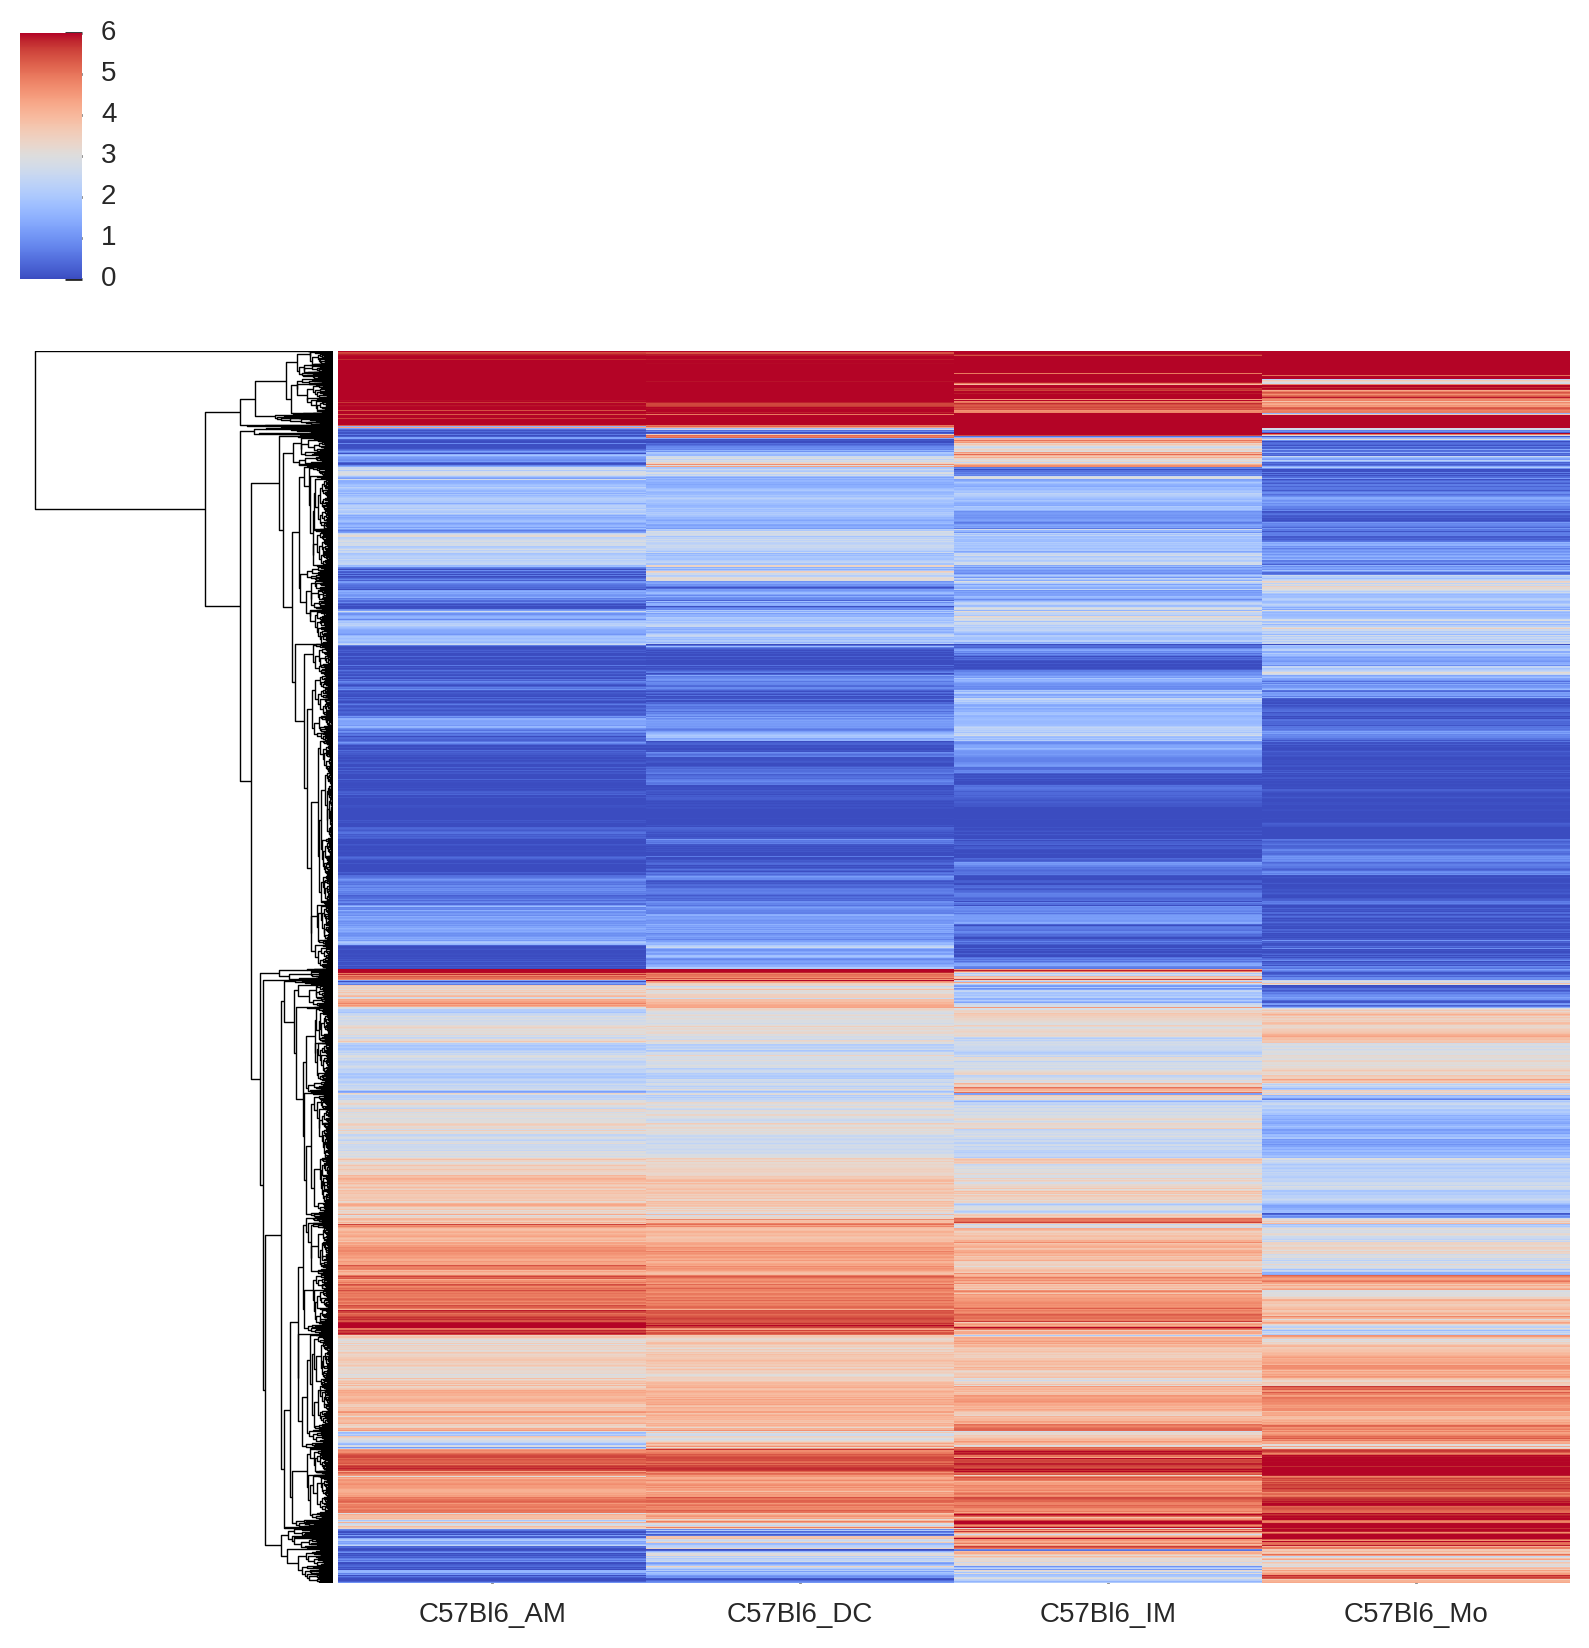

In [86]:
colorDict = dict(zip(range(10), sns.color_palette('Set1')))
features = np.log2(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(down_diff_genes+up_diff_genes)]+1)
# est = KMeans(n_clusters=4, n_jobs=4)
# est.fit(features)
# colors = [colorDict[x] for x in est.labels_]
features = features[['C57Bl6_AM', 'C57Bl6_DC','C57Bl6_IM', 'C57Bl6_Mo']]
sns.clustermap(data=features, yticklabels=False, cmap='coolwarm',col_cluster=False,vmax=6)
plt.savefig('adult_heatmap.pdf')